In [346]:
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.ndimage import median_filter

from source.helper import to_dB, print_spectogram, gen_spectogram, diff_frames

In [347]:
BASE_DIR = Path("E:/radar-project/data")  # change to your project dir

loaded_file = h5py.File(BASE_DIR / 'complete_dataset.h5', 'r')

In [348]:
loaded_file['2023_03_21'].keys()

<KeysViewHDF5 ['background', 'bartek_sciana', 'biegunko_1os_2m_rafal', 'chodzonko_1os_2m_bartek', 'chodzonko_1os_4-1-8m_bartek', 'chodzonko_2os_2m_bartek_3m_oskar', 'chodzonko_2os_2m_oskar_3m_bartek', 'odleglosc_1m_bartek_bokiem', 'odleglosc_1m_bartek_przodem', 'odleglosc_2m_bartek_bokiem', 'odleglosc_2m_bartek_przodem', 'odleglosc_3m_bartek_bokiem', 'odleglosc_3m_bartek_przodem', 'odleglosc_4m_bartek_bokiem', 'odleglosc_4m_bartek_przodem', 'randomowe_chodzonko_1os_bartek', 'randomowe_chodzonko_3os', 'wiatrak_1m', 'wiatrak_2m', 'wiatrak_2m_bartek_sciana', 'wiatrak_3m', 'wiatrak_4m', 'wysoki_niski_3m_oskar_bartek_przodem']>

In [349]:
sample_file = loaded_file['2023_03_21']['chodzonko_1os_4-1-8m_bartek']
sample_file = sample_file[:, 0, 0, :]

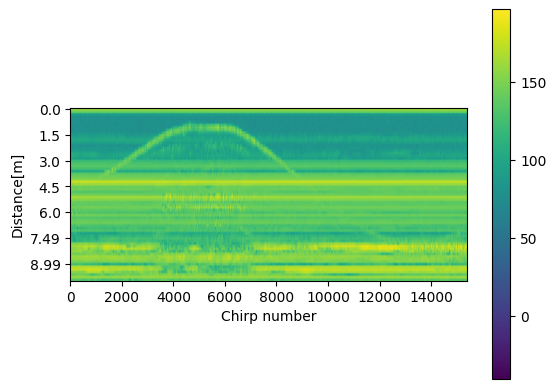

In [350]:
normal_spect, y = gen_spectogram(sample_file)
normal_spect = to_dB(normal_spect)
print_spectogram(normal_spect, y, depth_limit=10)

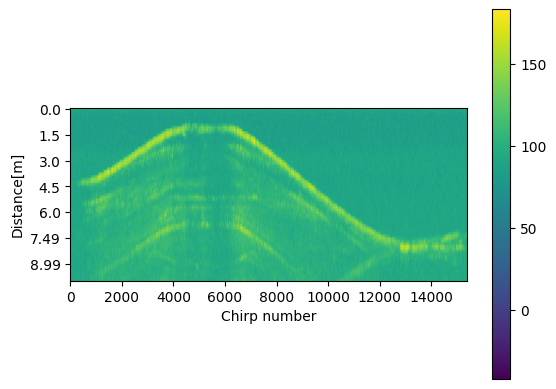

In [388]:
frames_diff = diff_frames(sample_file, 1)  #odejmujemy ostatnią klatkę
diff_spect, y = gen_spectogram(frames_diff)
diff_spectdb = to_dB(diff_spect)
print_spectogram(diff_spectdb, y, depth_limit=10)

In [391]:
# import cv2
# ret2,th2 = cv2.threshold(diff_spectdb.astype('uint8'),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# print_spectogram(th2, y, depth_limit=10)

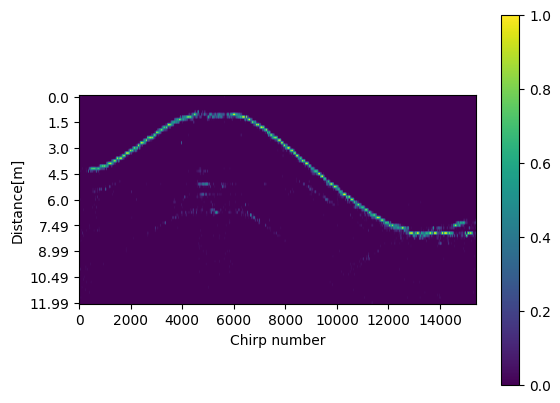

In [394]:
tresholded = np.zeros_like(diff_spectdb)
max_indices = np.argmax(diff_spectdb, axis=0)
tresholded[max_indices, np.arange(diff_spectdb.shape[1])] = 1
print_spectogram(tresholded, y, depth_limit=12)

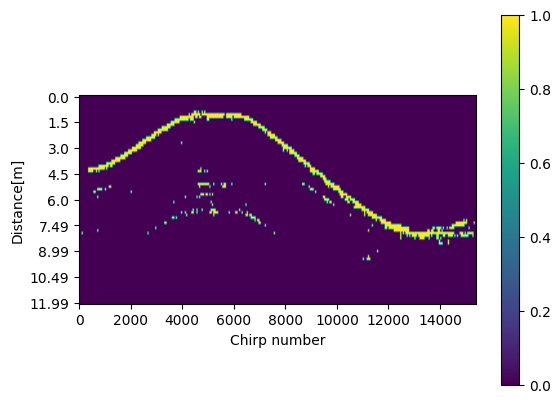

In [460]:
# NORMAL, DIFFERENTIAL, TRESHOLDED ARGMAX

CHIRP_STEP = 50
BIN_STEP = 1

modded_spectrogram = np.zeros_like(tresholded)
how_many_ones_to_follow = int(CHIRP_STEP * BIN_STEP * 0.05)

current_object_coordinates = None
for column in range(0 + CHIRP_STEP, tresholded.shape[1] - CHIRP_STEP, CHIRP_STEP):
    for row in range(0 + BIN_STEP, tresholded.shape[0] - BIN_STEP, BIN_STEP):
        non_zeros = np.count_nonzero(tresholded[row:row+BIN_STEP, column:column+CHIRP_STEP] == 1)

        if non_zeros > how_many_ones_to_follow:
            current_object_coordinates = [row, row+BIN_STEP, column, column+CHIRP_STEP]
            modded_spectrogram[row:row+BIN_STEP, column:column+CHIRP_STEP] = normal_spect[row:row+BIN_STEP, column:column+CHIRP_STEP]
            continue
        #
        # elif non_zeros <= how_many_ones_to_follow and current_object_coordinates:
        #     if current_object_coordinates[:2] == [row, row+BIN_STEP]:
        #         modded_spectrogram[row:row+BIN_STEP, column:column+CHIRP_STEP] = normal_spect[row:row+BIN_STEP, column:column+CHIRP_STEP]
        #         continue
            # else: break
modded_spectrogram = np.where(modded_spectrogram > 0, 1, 0)
print_spectogram(modded_spectrogram, y, depth_limit=12)

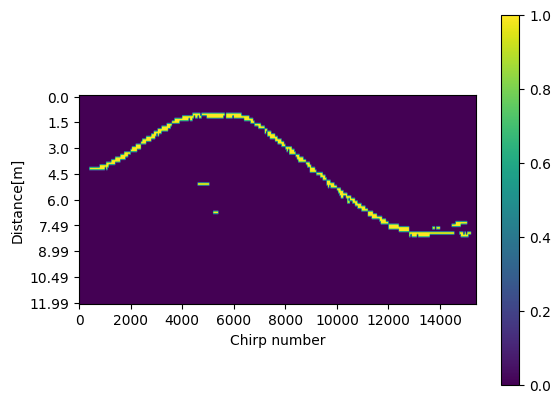

In [398]:
CHIRP_STEP = 400
BIN_STEP = 1

filtered_spectrogram = np.zeros_like(modded_spectrogram)
how_many_ones_to_follow = int(CHIRP_STEP * BIN_STEP * 0.12)

for column in range(0 + CHIRP_STEP, tresholded.shape[1] - CHIRP_STEP, CHIRP_STEP):
    for row in range(0 + BIN_STEP, tresholded.shape[0] - BIN_STEP, BIN_STEP):
        non_zeros = np.count_nonzero(tresholded[row:row+BIN_STEP, column:column+CHIRP_STEP] == 1)
        if non_zeros > how_many_ones_to_follow:
            filtered_spectrogram[row:row+BIN_STEP, column:column+CHIRP_STEP] = modded_spectrogram[row:row+BIN_STEP, column:column+CHIRP_STEP]

print_spectogram(filtered_spectrogram, y, depth_limit=12)

In [399]:
# smoothed_array = median_filter(filtered_spectrogram, size=(2, 6), mode='nearest')
# print_spectogram(smoothed_array, y, depth_limit=12)

In [457]:
box_cropped = np.copy(filtered_spectrogram)
box_list = []
number_of_boxes = 500
window_size = 500
indices_smoothed = np.argmax(filtered_spectrogram, axis=0)
# indices_smoothed = np.mean(filtered_spectrogram, axis=0)
for img_column_idx in range(0, box_cropped.shape[1] - window_size, int(box_cropped.shape[1] / number_of_boxes)):
    box_list.append(indices_smoothed[img_column_idx: img_column_idx + window_size])

In [458]:
box_means = [box.mean() for box in box_list]
box_vars = [box.var() for box in box_list]
box_skew = [np.nan_to_num(scipy.stats.skew(box)) for box in box_list]
box_kurt = [np.nan_to_num(scipy.stats.kurtosis(box)) for box in box_list]

# box_means = median_filter(box_means, size=10)
# box_vars = median_filter(box_vars, size=10)
# box_skew = median_filter(box_skew, size=10)
# box_kurt = median_filter(box_kurt, size=10)

C:\Users\cubix\AppData\Local\Temp\ipykernel_1260\1374098871.py:3: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  box_skew = [np.nan_to_num(scipy.stats.skew(box)) for box in box_list]
C:\Users\cubix\AppData\Local\Temp\ipykernel_1260\1374098871.py:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  box_kurt = [np.nan_to_num(scipy.stats.kurtosis(box)) for box in box_list]


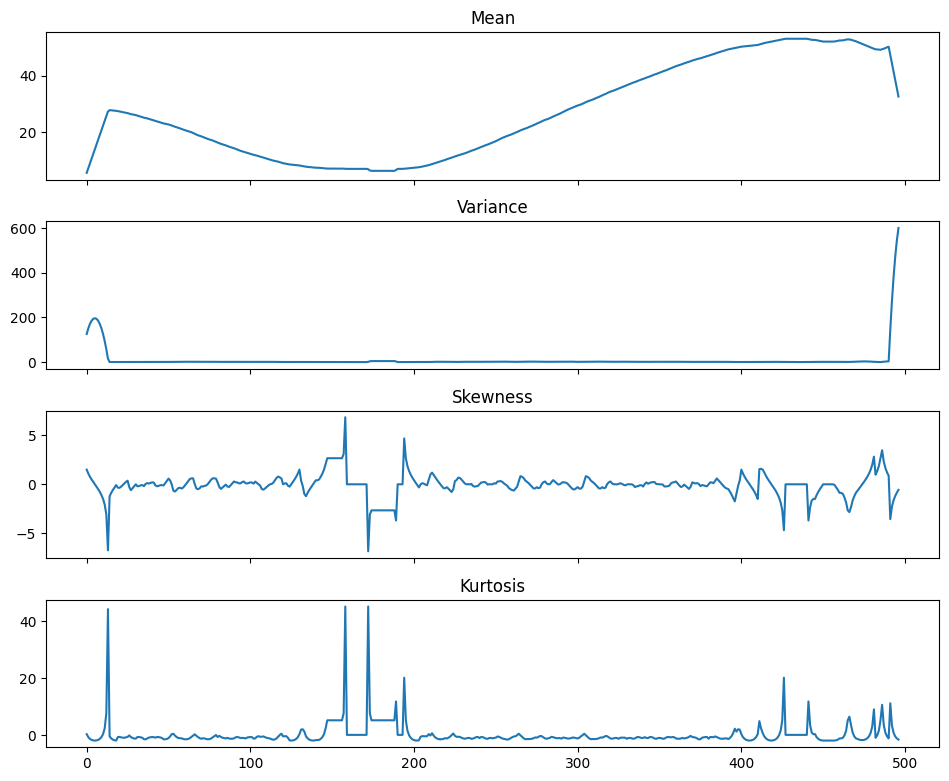

In [459]:
fig, axs = plt.subplots(4, figsize=(10,8), sharex='all')
fig.tight_layout(pad=2)

axs[0].plot(box_means)
axs[0].set_title('Mean')
axs[1].plot(box_vars)
axs[1].set_title('Variance')
axs[2].plot(box_skew)
axs[2].set_title('Skewness')
axs[3].plot(box_kurt)
axs[3].set_title('Kurtosis')

plt.show()

In [434]:
# plt.plot(box_means)
# plt.yticks(np.arange(start=0, stop=81, step=10), y[:81:10])
# plt.show()